# Theory and Toy Problems

In [80]:
import graph_structure as gs
import numpy as np
from tqdm import tqdm
from joblib import Parallel,delayed
import matplotlib.pyplot as plt
import scipy.stats as st

# Adding white noise

In [81]:
n_samples = 100
dim = 50
snrs = [-20, -10, 0, 10, 20, 30, 40] # dB
ks = list(range(1, n_samples))

In [82]:
def alpha_from_snr(snr):
    return 10**(-snr / 20)

def make_curves(seed, n_samples, dim, snrs, ks):    
    np.random.seed(seed)
    x = np.random.randn(n_samples, dim)
    nx = gs.nearest_neighbors(x)
    curves = []
    for snr in snrs:
        alpha = alpha_from_snr(snr)
        y = x + alpha * (np.random.randn(n_samples, dim))
        ny = gs.nearest_neighbors(y)
        res = []
        for k in ks:
            if k == 0:
                res.append(0)
                continue
            res.append(gs.mean_neighborhood_similarity_from_neighborhood(nx, ny, k))
        curves.append(res)

    return np.array(curves)

In [83]:
n_samples = 100
dim = 50
snrs = [-20, -10, 0, 10, 20, 30, 40] # dB
ks = list(range(1, n_samples))
all_curves = Parallel(n_jobs=-1, verbose=10)(delayed(make_curves)(n, n_samples, dim, snrs, ks)
                                             for n in range(48))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  48 | elapsed:    3.9s remaining:   59.1s
[Parallel(n_jobs=-1)]: Done   8 out of  48 | elapsed:    4.3s remaining:   21.7s
[Parallel(n_jobs=-1)]: Done  13 out of  48 | elapsed:    4.5s remaining:   12.1s
[Parallel(n_jobs=-1)]: Done  18 out of  48 | elapsed:    4.5s remaining:    7.5s
[Parallel(n_jobs=-1)]: Done  23 out of  48 | elapsed:    4.5s remaining:    4.9s
[Parallel(n_jobs=-1)]: Done  28 out of  48 | elapsed:    4.6s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done  33 out of  48 | elapsed:    4.6s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  38 out of  48 | elapsed:    4.6s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  43 out of  48 | elapsed:    4.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    4.7s finished


In [84]:
# Hypergeometric
# M = number of possibilities
# N = number of possibilities of victory
# n = number of trials
M = n_samples-1
n = ks
N = n
intersection = st.hypergeom.mean(M,n,N)
union = 2 * np.array(n) - np.array(intersection)
js = intersection/union

/home/tiago/miniconda3/envs/graph/lib/python3.11/site-packages/scipy/stats/_discrete_distns.py:654: RuntimeWarning: divide by zero encountered in divide
  g2 /= n * N * (M - N) * m * (M - 2.) * (M - 3.)
/home/tiago/miniconda3/envs/graph/lib/python3.11/site-packages/scipy/stats/_discrete_distns.py:658: RuntimeWarning: divide by zero encountered in _hypergeom_skewness
  _boost._hypergeom_skewness(n, N, M),


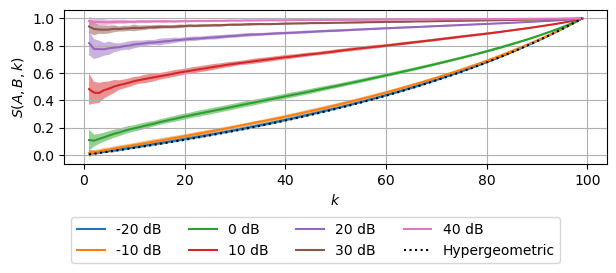

In [85]:

all_curves_ = np.array(all_curves)
curves = np.mean(all_curves_, axis=0)
errors = np.std(all_curves_, axis=0)*2

curves.shape
labels = [f'{s} dB' for s in snrs]

plt.figure(figsize=(7, 2))

for c in range(curves.shape[0]):
    plt.plot(ks, curves[c,:], label=labels[c])
    plt.fill_between(ks, curves[c,:]+errors[c,:], curves[c,:]-errors[c,:], alpha=0.5)

plt.plot(n, js, 'k:', label='Hypergeometric')

plt.xlabel('$k$')
plt.ylabel('$S(A,B,k)$')
a = 0.2
plt.yticks(np.arange(0, 1 + a, a))
#plt.semilogx()
plt.grid()
plt.legend(ncols=4, loc='upper left', bbox_to_anchor=(0.0, -0.3))
plt.savefig('sabk_white_noise_100.pdf', bbox_inches='tight')
plt.show()

/tmp/ipykernel_3479074/132127426.py:11: RuntimeWarning: invalid value encountered in divide
  yaxis = (np.array(curves[c,:])-np.array(js))/(1-np.array(js))


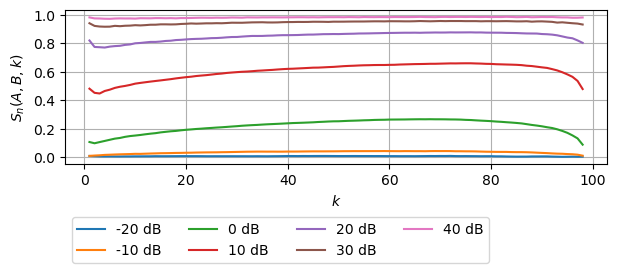

In [86]:

all_curves_ = np.array(all_curves)
curves = np.mean(all_curves_, axis=0)
errors = np.std(all_curves_, axis=0)*2

curves.shape
labels = [f'{s} dB' for s in snrs]

plt.figure(figsize=(7, 2))

for c in range(curves.shape[0]):
    yaxis = (np.array(curves[c,:])-np.array(js))/(1-np.array(js))
    plt.plot(ks, yaxis, label=labels[c])
    #plt.fill_between(ks, curves[c,:]+errors[c,:], curves[c,:]-errors[c,:], alpha=0.5)

#plt.plot(n, js, 'k:', label='Hypergeometric')

plt.xlabel('$k$')
plt.ylabel('$S_n(A,B,k)$')
a = 0.2
plt.yticks(np.arange(0, 1 + a, a))
#plt.semilogx()
plt.grid()
plt.legend(ncols=4, loc='upper left', bbox_to_anchor=(0.0, -0.3))

plt.savefig('sabk_white_noise_100_normalized.pdf', bbox_inches='tight')
plt.show()

# Impact of number of samples

In [87]:
n_samples_list = np.arange(30,200)
dim = 50
k = 0.2
snrs = [-20, -10, 0, 10, 20, 30, 40] 

res = {}
stds = {}
n_repetitions = 10

for snr in tqdm(snrs):
    res[snr] = []
    stds[snr] = []
    alpha = alpha_from_snr(snr)
    for n_samples in n_samples_list:
        this_res = []    
        for _ in range(n_repetitions):            
            A = np.random.randn(n_samples, dim)
            B = A + alpha * np.random.randn(n_samples, dim)
            k_ = int(k * n_samples)
            s = gs.mean_neighborhood_similarity_from_points(A, B, k_)
            this_res.append(s)
        res[snr].append(np.mean(this_res))
        stds[snr].append(np.std(this_res))

100%|██████████| 7/7 [00:42<00:00,  6.02s/it]


In [88]:
print(res)

{-20: [0.12021212121212124, 0.1162952101661779, 0.11849431818181819, 0.1161799816345271, 0.10670231729055257, 0.1354136974136974, 0.11623888457221791, 0.11838908838908839, 0.11105447184394553, 0.10681967605044529, 0.12207592407592412, 0.12473672668794622, 0.10993102135959283, 0.10701422608399355, 0.11418732782369148, 0.13039894419306183, 0.11702098732469572, 0.11852387599884469, 0.11300272644022642, 0.11642507552471537, 0.11242292004521104, 0.12000931779660602, 0.11249867693366142, 0.11787858473412534, 0.1119100174182733, 0.11941787400765722, 0.12327034322500925, 0.11685828347959677, 0.11121338462789832, 0.1136788048552754, 0.12116391459156306, 0.11815736451216821, 0.10947492426982139, 0.11531628808516688, 0.10938142354403801, 0.11700201375029744, 0.11110830495810727, 0.12168031133228026, 0.11150868044326105, 0.11309385295167795, 0.12187601030209727, 0.11495458897463603, 0.11409825118520771, 0.11025092728725845, 0.10746874542526721, 0.12122304245812487, 0.11581445577095772, 0.109145407

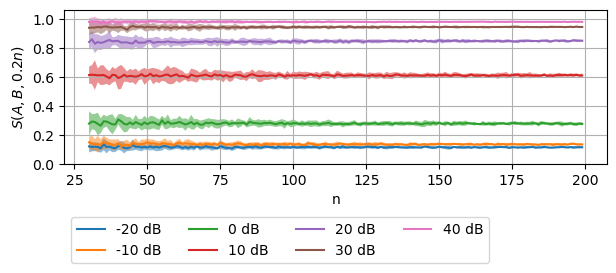

In [89]:

plt.figure(figsize=(7, 2))
labels = [f'{s} dB' for s in snrs]
for idx, snr in enumerate(snrs):
    plt.plot(n_samples_list, res[snr], label=labels[idx])
    plt.fill_between(n_samples_list, np.array(res[snr])+2*np.array(stds[snr]), np.array(res[snr])-2*np.array(stds[snr]), alpha=0.5)

#plt.plot(n, js, 'k:', label='Hypergeometric')

plt.xlabel('n')
plt.ylabel(f'$S(A,B,{k}n)$')
a = 0.2
plt.yticks(np.arange(0, 1 + a, a))
#plt.semilogx()
plt.grid()
plt.legend(ncols=4, loc='upper left', bbox_to_anchor=(0.0, -0.3))

plt.savefig('sabk_variation_of_n.pdf', bbox_inches='tight')
plt.show()

# 

# Impact of noise level

In [90]:
n_samples = 100
dim = 50
k = 20
snrs = [-20, -10, 0, 10, 20, 30, 40] # dB
snrs = np.linspace(-20, 60, 25)
alphas = np.sqrt(10**(-snrs / 10))
res = []
stds = []
n_repetitions = 10

for alpha in tqdm(alphas):
    this_res = []    
    for _ in range(n_repetitions):
        A = np.random.randn(n_samples, dim)
        B = A + alpha * np.random.randn(n_samples, dim)
        s = gs.mean_neighborhood_similarity_from_points(A, B, k)
        this_res.append(s)
    res.append(np.mean(this_res))
    stds.append(np.std(this_res))

100%|██████████| 25/25 [00:00<00:00, 36.16it/s]


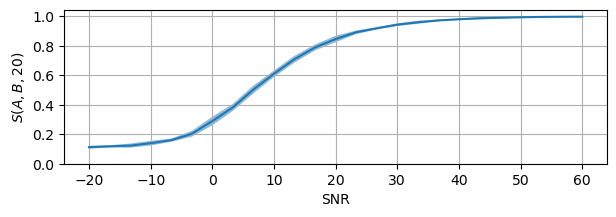

In [91]:
plt.figure(figsize=(7, 2))
snrs = np.array(snrs)
res = np.array(res)
stds = np.array(stds)

plt.plot(snrs, res)
plt.fill_between(snrs, res+np.array(stds)*2, res-np.array(stds)*2, alpha=0.5)
plt.xlabel('SNR')
plt.ylabel(f'$S(A,B,{k})$')
a = 0.2
plt.yticks(np.arange(0, 1 + a, a))
plt.xticks(range(-20, 61, 10))
plt.grid()
plt.savefig('sabk_by_snr.pdf', bbox_inches='tight')
plt.show()

# Impact of dimensions

In [92]:
# argmin_k S(k) and min S(k) do not correlate with dimension (only in <10 dimensions)
snrs = [-20, -10, 0, 10, 20, 30, 40]

dims = list(range(2, 100, 1))
n_samples = 100
k = 20
res = {}
stds = {}
n_repeats = 10
for snr in snrs:
    res[snr] = []
    stds[snr] = []
    for dim in tqdm(dims):
        argm = []
        m = []
        for n in range(n_repeats):
            x = np.random.randn(n_samples, dim)
            A = np.random.randn(n_samples, dim)
            alpha = alpha_from_snr(snr)
            B = A + alpha * np.random.randn(n_samples, dim)
            s = gs.mean_neighborhood_similarity_from_points(A, B, k)
            m.append(s)
        res[snr].append(np.mean(m))
        stds[snr].append(np.std(m))


100%|██████████| 98/98 [00:02<00:00, 33.84it/s]


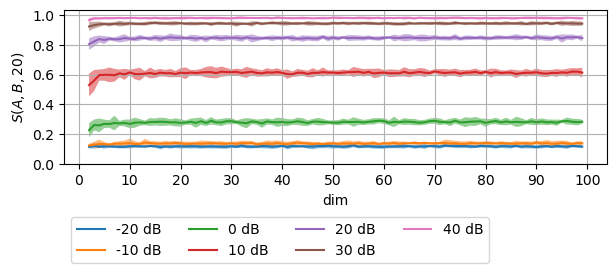

In [93]:
plt.figure(figsize=(7, 2))
for snr in snrs:
    plt.plot(dims, res[snr], label=f'{snr} dB')
    plt.fill_between(dims, res[snr]+np.array(stds[snr])*2, res[snr]-np.array(stds[snr])*2, alpha=0.5)
plt.xlabel('dim')
plt.ylabel(f'$S(A, B, {k})$')
plt.xticks(range(0, 110, 10))
a = 0.2
plt.yticks(np.arange(0, 1 + a, a))
plt.grid()
plt.legend(ncols=4, loc='upper left', bbox_to_anchor=(0.0, -0.3))
plt.savefig('sabk_dimensions.pdf', bbox_inches='tight')
plt.show()

# Changing the location of clusters

In [94]:
c = 5
n_clusters = 5
dim = 50
samples_per_cluster = 20
np.random.seed(65)
clusters = np.random.randn(n_clusters, dim) * c
clusters2 = np.random.randn(n_clusters, dim) * c

n_samples = samples_per_cluster * clusters.shape[0]


In [95]:
def make_curves_clusters(seed, samples_per_cluster, clusters, clusters2, dim, snrs, ks):    
    n_samples = samples_per_cluster * clusters.shape[0]
    np.random.seed(seed)
    x = np.vstack([np.random.randn(samples_per_cluster, dim) + clusters[i,:] for i in range(clusters.shape[0])])
    y = np.vstack([ np.random.randn(samples_per_cluster, dim) + clusters2[i,:]  for i in range(clusters.shape[0])])
    nx = gs.nearest_neighbors(x)
    curves = []
    for snr in snrs:
        alpha = alpha_from_snr(snr)
        y = x + alpha * (np.random.randn(n_samples, dim))
        ny = gs.nearest_neighbors(y)
        res = []
        for k in ks:
            if k == 0:
                res.append(0)
                continue
            res.append(gs.mean_neighborhood_similarity_from_neighborhood(nx, ny, k))
        curves.append(res)

    return np.array(curves)

In [96]:
n_samples = 100
dim = 50
snrs = [-20, -10, 0, 10, 20, 30, 40] # dB
ks = list(range(1, samples_per_cluster*clusters.shape[0]-1))
all_curves = Parallel(n_jobs=-1, verbose=10)(delayed(make_curves_clusters)(n, samples_per_cluster, clusters, clusters2, dim, snrs, ks)
                                             for n in range(48))


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  48 | elapsed:    1.9s remaining:   29.2s
[Parallel(n_jobs=-1)]: Done   8 out of  48 | elapsed:    2.0s remaining:   10.0s
[Parallel(n_jobs=-1)]: Done  13 out of  48 | elapsed:    2.0s remaining:    5.4s
[Parallel(n_jobs=-1)]: Done  18 out of  48 | elapsed:    2.0s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done  23 out of  48 | elapsed:    2.1s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  28 out of  48 | elapsed:    2.1s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  33 out of  48 | elapsed:    2.1s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  38 out of  48 | elapsed:    2.1s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  43 out of  48 | elapsed:    2.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    2.2s finished


In [97]:
# Hypergeometric
# M = number of possibilities
# N = number of possibilities of victory
# n = number of trials
M = n_samples-1
n = ks[:-2]
N = n
intersection = st.hypergeom.mean(M,n,N)
union = 2 * np.array(n) - np.array(intersection)
js = intersection/union

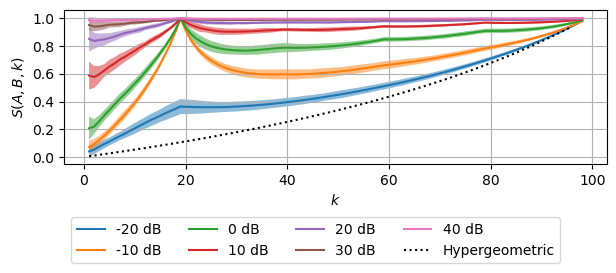

In [98]:
all_curves_ = np.array(all_curves)
curves = np.mean(all_curves_, axis=0)
errors = np.std(all_curves_, axis=0)*2

curves.shape
labels = [f'{s} dB' for s in snrs]

plt.figure(figsize=(7, 2))

for c in range(curves.shape[0]):
    plt.plot(ks, curves[c,:], label=labels[c])
    plt.fill_between(ks, curves[c,:]+errors[c,:], curves[c,:]-errors[c,:], alpha=0.5)

plt.plot(n, js, 'k:', label='Hypergeometric')

plt.xlabel('$k$')
plt.ylabel('$S(A,B,k)$')
a = 0.2
plt.yticks(np.arange(0, 1 + a, a))
#plt.semilogx()
plt.grid()
plt.legend(ncols=4, loc='upper left', bbox_to_anchor=(0.0, -0.3))
plt.savefig('clustered_with_whitenoise.pdf', bbox_inches='tight')
plt.show()